## repeataly

**predicting repeat customers with sales data**

zen yui | 2016-03-05

### notes:
- k-means to segment
- logistic regression for feature selection
- random forest for prediction

In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from __future__ import division
%matplotlib inline

In [2]:
from datetime import date, timedelta

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split, ShuffleSplit
from sklearn.grid_search import GridSearchCV

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [178]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
# use ggplot style
plt.style.use('ggplot')

### import CSV data

In [156]:
# get all data files
fp = os.path.join('data','post_eda')
files = [os.path.join(fp, f) for f in os.listdir(fp)]

In [157]:
# read all files into one dataframe
df_read = pd.read_csv(files[0])

for f in files[1:]:
    df_read = df_read.append(pd.read_csv(f), ignore_index=True)

In [158]:
df = df_read.copy()
df.head().T

,0,1,2,3,4
TicketTime,11.783,11.900,12.067,12.083,12.100
PriorVisits,0,3,1,0,1
GiftCardLines,0,0,0,0,0
NetAmount,3.200,53.000,44.600,38.400,14.400
DiscountAmount,0.000,0.000,0.000,0.000,0.000
UniqueItems,1,2,3,2,2
UniqueCategories,1,1,2,1,1
ReturnedBags,False,False,False,False,False
BoughtProduce,False,False,False,False,False
TicketMonthDecimal,5.312,5.312,5.312,5.312,5.312


### separate shoppers during business hours

In [159]:
df_biz = df[(df['TicketTime']<17) & (df['WeekdayNumber'] < 6)]

In [160]:
df_nobiz = df[(df['TicketTime']>=17) | (df['WeekdayNumber'] > 6)]

### split data into test/train sets

In [161]:
# separate the data set into features and prediction
X = df_nobiz.drop('WillReturn',axis=1).copy()
y = df_nobiz['WillReturn']

In [162]:
# split into test/train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=7)

### inspecting into correlation of features
- as expected, some features have very high correlations
    - Sales Lines & Net Amount
    - Net Amount & Net Retail Amount
    - Sale Lines & Unique Items


- ML algorithm will have to accomodate highly-correlated features

In [163]:
# find correlations between 
Xcorr = X.corr()
Xcorr.where((Xcorr >.5) & (Xcorr < 1),'')

,TicketTime,PriorVisits,GiftCardLines,NetAmount,DiscountAmount,UniqueItems,UniqueCategories,ReturnedBags,BoughtProduce,TicketMonthDecimal,WeekdayNumber,IsFrontEnd,RetailSpendCnt,QSRSpendCnt,TicketCount,BizHours
TicketTime,,,,,,,,,,,,,,,,
PriorVisits,,,,,,,,,,,,,,,,
GiftCardLines,,,,,,,,,,,,,,,,
NetAmount,,,,,,0.772,0.671,,,,,,0.971,,,
DiscountAmount,,,,,,,,,,,,,,,,
UniqueItems,,,,0.772,,,0.867,,0.537,,,,0.776,,,
UniqueCategories,,,,0.671,,0.867,,,0.583,,,0.506,0.690,,,
ReturnedBags,,,,,,,,,,,,,,,,
BoughtProduce,,,,,,0.537,0.583,,,,,,,,,
TicketMonthDecimal,,,,,,,,,,,,,,,,


### applying k-means clusters as a feature
- from preliminary analysis, k-means clusters seem well-defined and intuitive from a business perspective
- the goal of this project is to better understand and segment customers, so clustering is very important

In [164]:
km_cols = ['PriorVisits','NetAmount','UniqueItems','UniqueCategories'
           ,'BoughtProduce','IsFrontEnd','RetailSpendCnt','QSRSpendCnt']

In [165]:
X_train_km = X_train[km_cols].copy()
X_test_km = X_test[km_cols].copy()

km_drop_cols = ['TicketTime', 'GiftCardLines', 'NetAmount','DiscountAmount','TicketMonthDecimal', 'WeekdayNumber']
X_train_km = X_train.drop(km_drop_cols, axis=1).copy()
X_test_km = X_test.drop(km_drop_cols, axis=1).copy()

In [166]:
# scale features for k-means cluster
scale = StandardScaler()
scale.fit(X_train_km)
X_train_km_std = scale.transform(X_train_km)
X_test_km_std = scale.transform(X_test_km)

In [230]:
# finding the elbow plotting inertia
k = []
i = []
for n in range(1,8):
    #km2 = KMeans(n_clusters=n, n_jobs=-1, random_state=7)
    km2 = MiniBatchKMeans(n_clusters=n, n_init=100, random_state=7)
    km2.fit(X_train_km)
    k.append(n)
    i.append(km2.inertia_)

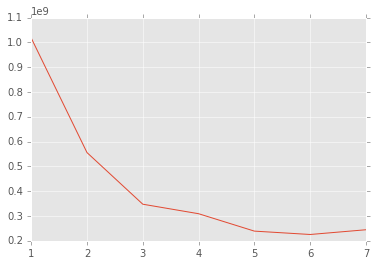

In [231]:
# plotting clusters vs inertia
plt.plot(k, i);

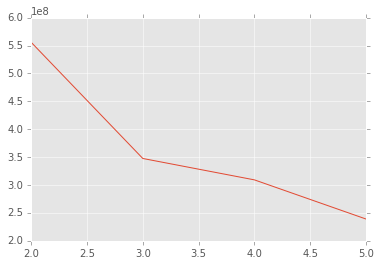

In [232]:
# plotting clusters vs inertia, zoomed in
plt.plot(k[1:5], i[1:5]);

In [233]:
# create kmeans with  clusters, get cluster labels
# km = KMeans(n_clusters=3, n_init=20, n_jobs=-1, random_state=7)
km = MiniBatchKMeans(n_clusters=3, n_init=100, random_state=7)
km.fit(X_train_km_std)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=3,
        n_init=100, random_state=7, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [234]:
# get specific inertia
print('inertia:\t {:.2f}'.format(km.inertia_))

inertia:	 2801557.14


In [235]:
# show cluster centers
pd.set_option('display.float_format', lambda x: '%.3f' % x)
columns = {str(x): scale.inverse_transform(km.cluster_centers_[x]) for x in range(0,len(km.cluster_centers_))}
dfclus = pd.DataFrame(columns, index=X_train_km.columns).copy()
#dfclus.columns=['Sampler','Lunch Junkie','Regular','Pro']
dfclus

,0,1,2
PriorVisits,5.163,2.412,8.315
NetAmount,97.238,15.854,27.246
UniqueItems,10.766,1.899,4.692
UniqueCategories,5.665,1.404,3.186
BoughtProduce,0.665,0.009,0.888
IsFrontEnd,0.984,0.358,0.957
RetailSpendCnt,2.719,0.302,0.754
QSRSpendCnt,0.161,0.432,0.090


In [236]:
# put k-means cluster labels on original dataset
dfkm_train = pd.DataFrame(data=km.predict(X_train_km_std), index=X_train.index, columns=['km_label'])
X_train_2 = pd.concat([X_train,dfkm_train], axis=1)

dfkm_test = pd.DataFrame(data=km.predict(X_test_km_std), index=X_test.index, columns=['km_label'])
X_test_2 = pd.concat([X_test, dfkm_test], axis=1)

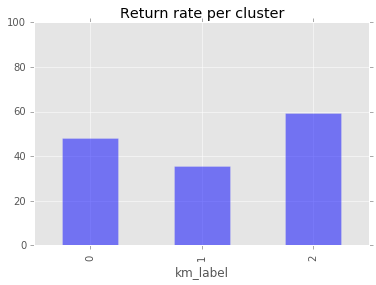

In [237]:
# return rate per cluster label
rrdf = (pd.concat([X_train_2, y_train], axis=1).groupby('km_label')['WillReturn'].mean() * 100)
rrdf.plot(kind='bar', ylim=(0,100), color='b', alpha=.5, title='Return rate per cluster');

### helper function for scoring models

In [238]:
def all_score(mod_nam, mod, X_test, y_test):
    '''Score model according to accuracy, recall, and f1 score
        and returns dataframe of scores'''
    y_pred = mod.predict(X_test)
    
    scores = {}
    scores['test_name'] = ['accuracy','precision','recall','f1']
    scores['test_score'] = []
    
    scores['test_score'].append(round(accuracy_score(y_test, y_pred) * 100, 2))
    scores['test_score'].append(round(precision_score(y_test, y_pred) * 100, 2))
    scores['test_score'].append(round(recall_score(y_test, y_pred) * 100, 2))
    scores['test_score'].append(round(f1_score(y_test, y_pred) * 100, 2))
    
    return pd.DataFrame(scores)

### applying random forest classifier for predictions
- random forest should perform well given:
    - correlated features
    - outliers
    - non-linear complexity

In [242]:
# create and fit random forest classifier
rf = RandomForestClassifier(n_estimators = 30, random_state = 7, n_jobs = -1)
rf.fit(X_train_2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=7, verbose=0, warm_start=False)

In [243]:
# scoring the random forest classifier
all_score('RF', rf, X_test_2, y_test).sort_values('test_score', ascending=False)

,test_name,test_score
0,accuracy,72.420
1,precision,71.650
3,f1,64.630
2,recall,58.860


In [244]:
# show feature importance
dfrf = pd.DataFrame({'Features':X_train_2.columns, 'Importance':rf.feature_importances_})
dfrf.sort_values('Importance', inplace=True, ascending=False)
dfrf

,Features,Importance
1,PriorVisits,0.224
0,TicketTime,0.147
14,TicketCount,0.119
9,TicketMonthDecimal,0.115
3,NetAmount,0.110
12,RetailSpendCnt,0.096
13,QSRSpendCnt,0.049
10,WeekdayNumber,0.036
5,UniqueItems,0.035
6,UniqueCategories,0.021


In [247]:
X_train_2.head()

,TicketTime,PriorVisits,GiftCardLines,NetAmount,DiscountAmount,UniqueItems,UniqueCategories,ReturnedBags,BoughtProduce,TicketMonthDecimal,WeekdayNumber,IsFrontEnd,RetailSpendCnt,QSRSpendCnt,TicketCount,BizHours,km_label
942206,18.500,0,0,12.840,0.000,3,3,False,True,6.839,5,True,0.396,0.000,350,False,2
138019,17.783,1,0,33.400,0.000,3,2,False,False,6.839,4,True,1.064,0.000,381,False,1
1286221,21.767,0,0,5.420,0.000,1,1,False,False,11.323,2,False,0.000,0.416,166,False,1
213986,20.000,0,0,14.600,0.000,2,2,False,False,7.938,3,True,0.469,0.000,313,False,1
187790,19.967,11,0,9.600,0.000,1,1,False,False,7.750,4,False,0.000,0.853,337,False,1


### applying logistic regression to the data

In [248]:
# create cross validation
cv = ShuffleSplit(X_train_2.shape[0], n_iter=10, test_size=0.25, random_state=7)

In [249]:
parameters = {'C': np.linspace(1e-6, 1e6, 5), 'class_weight': [None, 'balanced']}
lr = LogisticRegression(penalty='l2', random_state=7)

In [260]:
lr = LogisticRegression(penalty='l1', random_state=7, C=.001, class_weight='balanced')
lr.fit(X_train_2, y_train)

LogisticRegression(C=0.001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=7,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [261]:
all_score('lr',lr, X_test_2, y_test)

,test_name,test_score
0,accuracy,73.810
1,precision,77.290
2,recall,54.990
3,f1,64.260


In [262]:
pd.DataFrame({'features': X_train_2.columns, 'coefficients': lr.coef_[0]})

,coefficients,features
0,-0.028,TicketTime
1,0.235,PriorVisits
2,0.000,GiftCardLines
3,-0.003,NetAmount
4,0.090,DiscountAmount
5,0.020,UniqueItems
6,0.000,UniqueCategories
7,0.000,ReturnedBags
8,0.448,BoughtProduce
9,-0.012,TicketMonthDecimal


In [250]:
lr_best = GridSearchCV(lr, parameters, cv=cv)

In [251]:
lr_best.fit(X_train_2, y_train)

KeyboardInterrupt: 